## Importing Data and Libraries

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

import copy
import time

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

data = breast_cancer_wisconsin_diagnostic.data.features
data['labels'] = breast_cancer_wisconsin_diagnostic.data.targets

print(data.info())

## Pre-processing Data: Cleaning, Equalizing, and LabelEncoding

In [ ]:
missing = data.isnull().sum()
duplicates = data.duplicated().sum()

data = data.dropna()
data = data.drop_duplicates()

print("Missing values removed:\n" + str(missing))
print("\nDuplicates removed:", duplicates)

Missing values removed:
radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
labels                0
dtype: int64

Duplicates removed: 0


In [ ]:
# Balancing the data here to remove the class imbalance. Tried exploring class_weights to address imbalance, but ran into issues with Pytorch.
# Hence used this approach as an alternative

classCount = data['labels'].value_counts()
minClassCount = classCount.min()
newData = pd.DataFrame(columns=data.columns)

for label in classCount.index:
      classSamples = data[data['labels'] == label]
      newSamples = classSamples.sample(minClassCount)
      newData = pd.concat([newData, newSamples])

data = newData
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 217 to 297
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             424 non-null    float64
 1   texture1            424 non-null    float64
 2   perimeter1          424 non-null    float64
 3   area1               424 non-null    float64
 4   smoothness1         424 non-null    float64
 5   compactness1        424 non-null    float64
 6   concavity1          424 non-null    float64
 7   concave_points1     424 non-null    float64
 8   symmetry1           424 non-null    float64
 9   fractal_dimension1  424 non-null    float64
 10  radius2             424 non-null    float64
 11  texture2            424 non-null    float64
 12  perimeter2          424 non-null    float64
 13  area2               424 non-null    float64
 14  smoothness2         424 non-null    float64
 15  compactness2        424 non-null    float64
 16  concav

In [ ]:
# Encoding the labels with 0 and 1

featuresRaw = data.drop('labels', axis=1)
labelsRaw = data.labels

labelMapping = {}

labelEncoder = LabelEncoder()
labelsEncoded = labelEncoder.fit_transform(labelsRaw)

for class_ in labelEncoder.classes_:
  encoding = labelEncoder.transform([class_])[0]
  labelMapping[encoding] = class_

labels = labelsEncoded
print(labelMapping)

{0: 'B', 1: 'M'}


## Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(featuresRaw, labels, test_size=0.3, random_state=42)

trainScaler = StandardScaler()
X_train = trainScaler.fit_transform(X_train)
X_test = trainScaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=featuresRaw.columns)
X_test_df = pd.DataFrame(X_test, columns=featuresRaw.columns)

X_train_df.head()

X_data = np.array(featuresRaw)
y_data = np.array(labels)

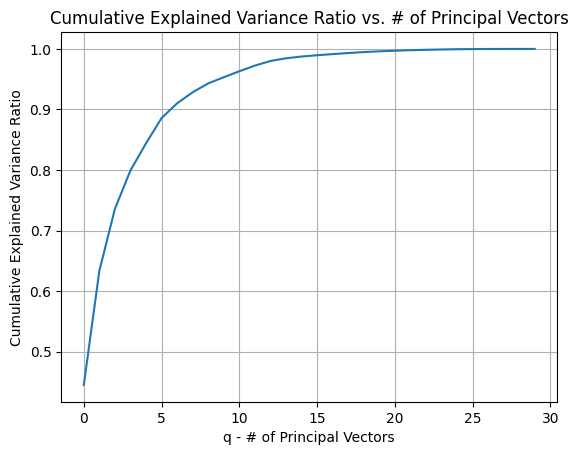

# of principal vectors for 95% of the variance: 10


In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

varianceRatio = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.95

principalVectors = np.argmax(varianceRatio >= threshold) + 1
X_train_reduced = X_train_pca[:, :principalVectors]

plt.plot(varianceRatio)
plt.xlabel('q - # of Principal Vectors')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. # of Principal Vectors')
plt.grid(True)
plt.show()
print('# of principal vectors for 95% of the variance:', principalVectors)

## Feature Visualization

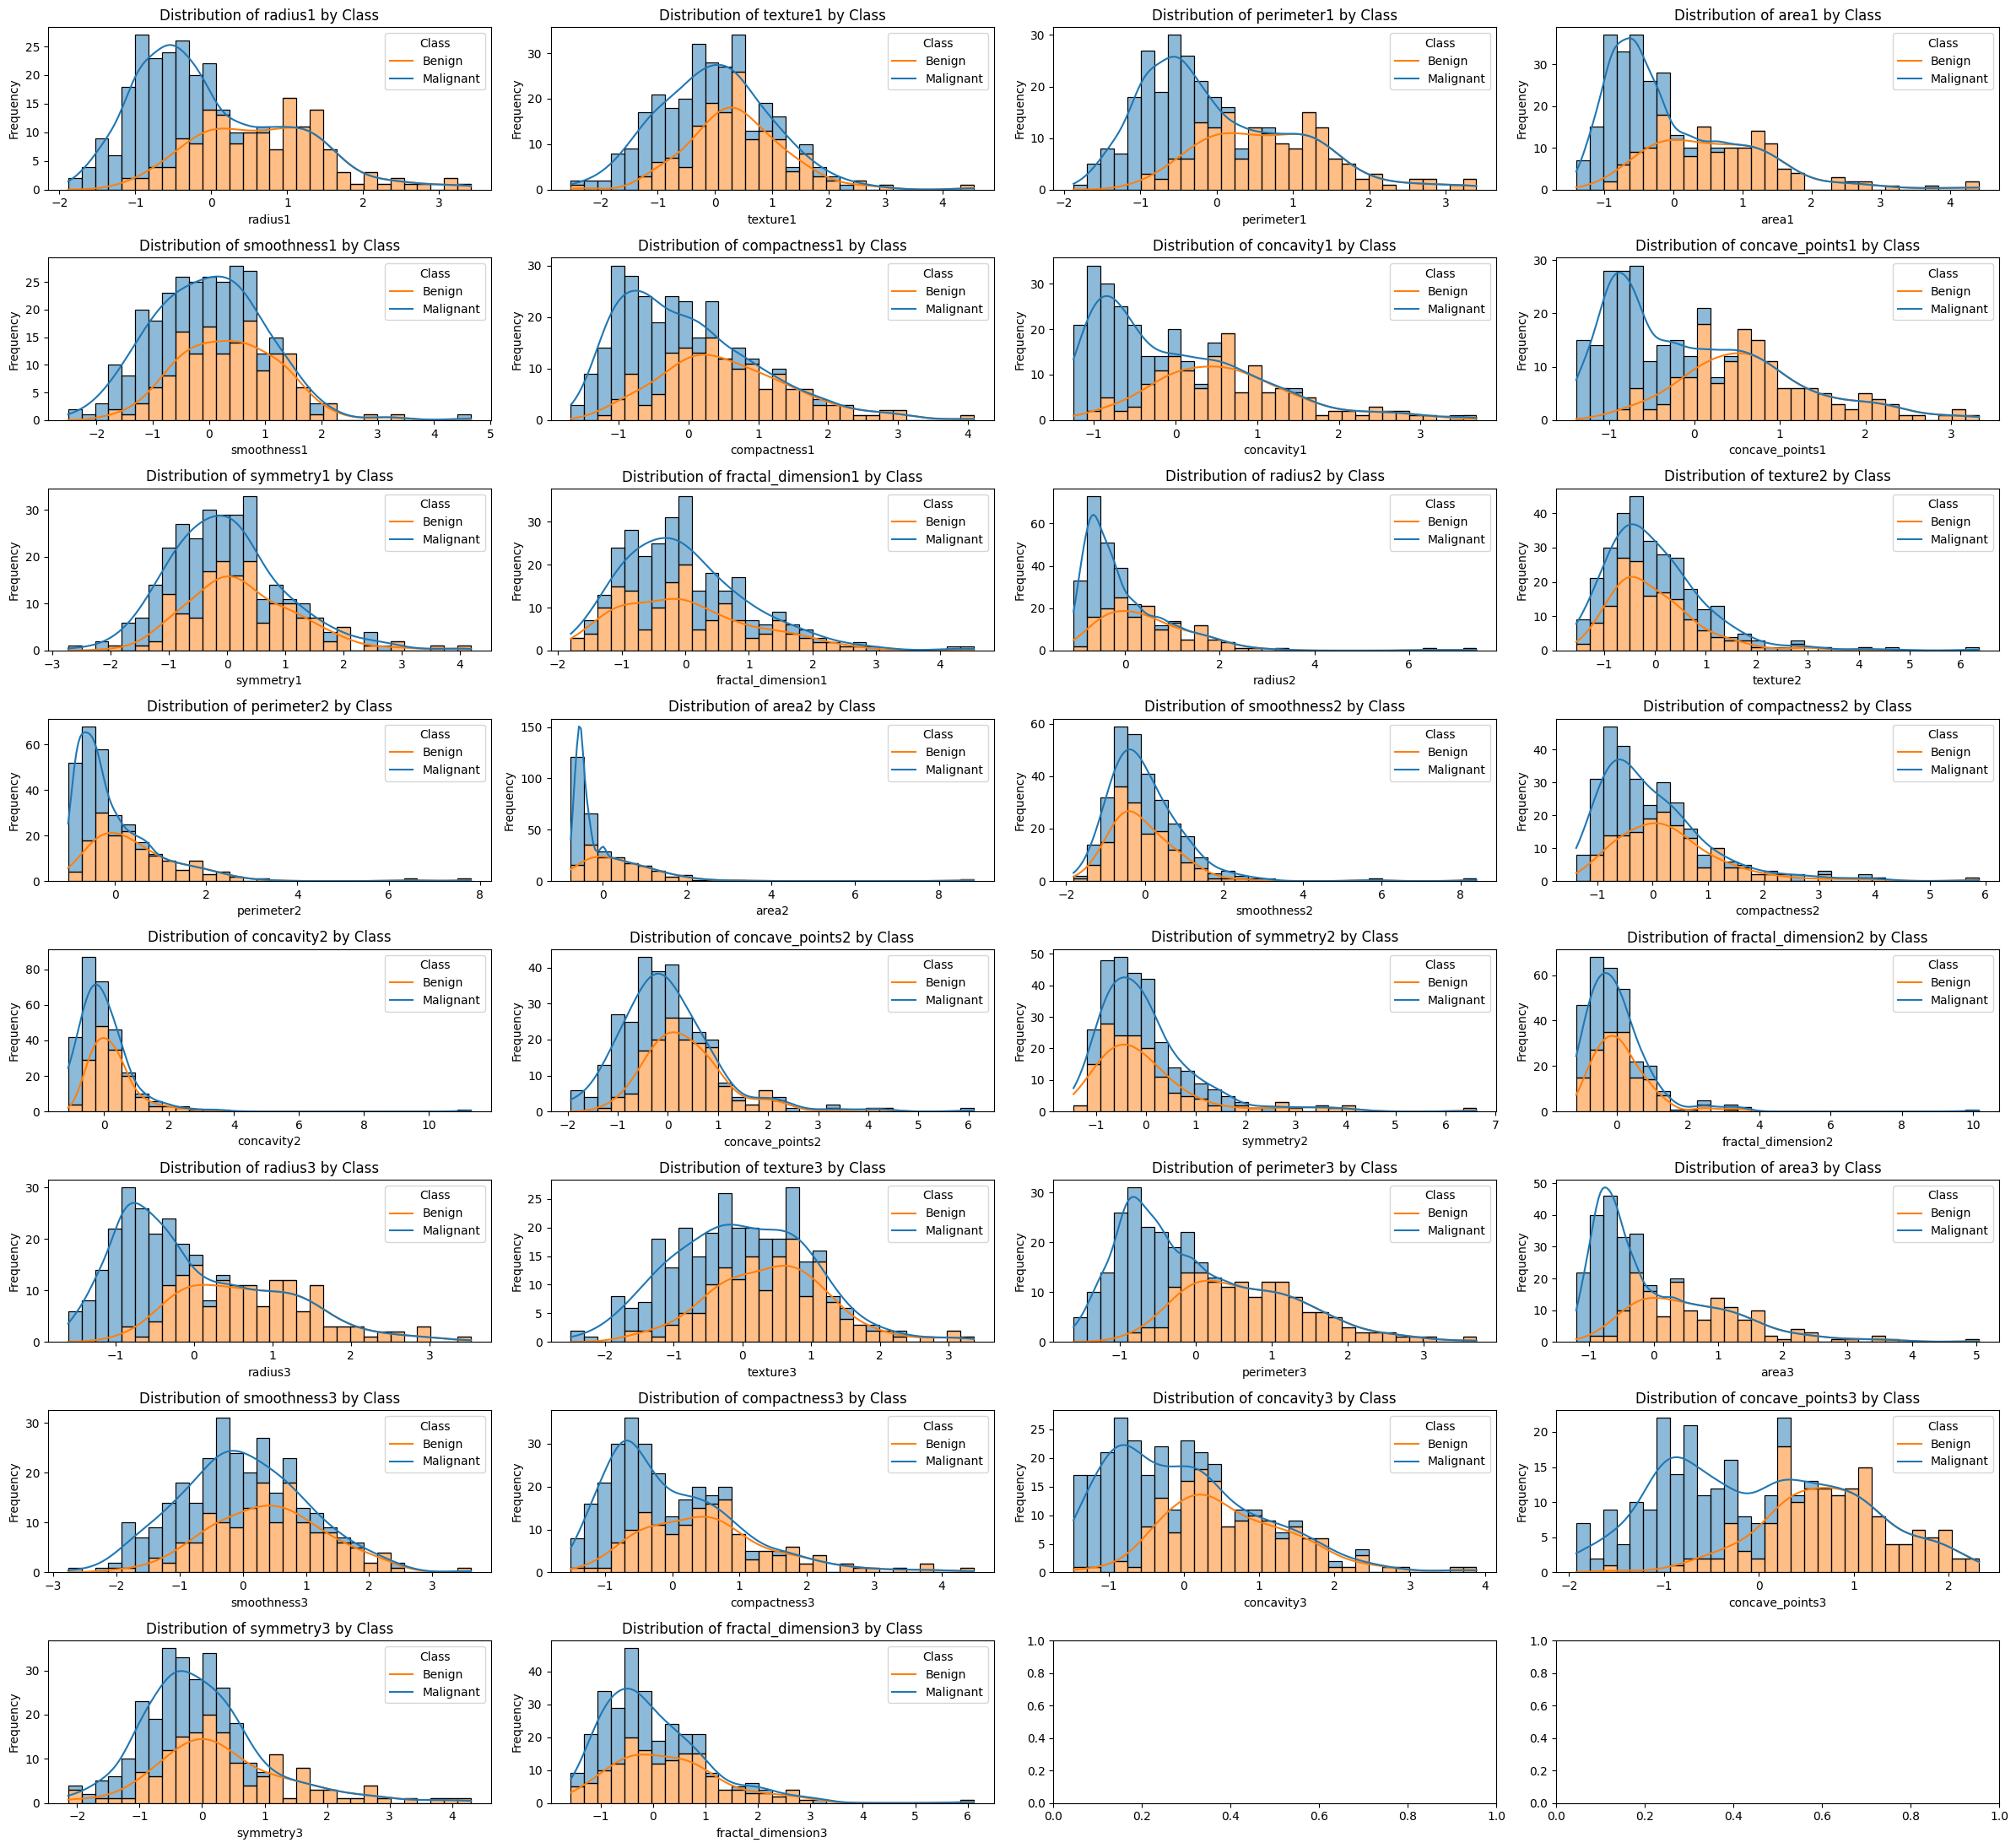

In [ ]:
# Visualizing the spread of data-points of feature for the two classes. Interesting to observe how they take a guassian shape, and
# gives an intutive sense of how a high-dimensional decision boundarys might separate them.

featuresLabelsDf = copy.deepcopy(X_train_df)
featuresLabelsDf['labels'] = copy.deepcopy(y_train)

col = len(featuresLabelsDf.columns) - 1
num_rows = (col - 1) // 4 + 1
num_cols = min(col, 4)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 22))
for i, column in enumerate(featuresLabelsDf.columns[:-1]):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(featuresLabelsDf, x=column, hue='labels', kde=True, multiple='stack', bins=30, ax=axes[row, col])
    axes[row,col].set_title('Distribution of ' + str(column) + ' by Class')
    axes[row,col].set_xlabel(column)
    axes[row,col].set_ylabel('Frequency')
    axes[row,col].legend(title='Class', labels=['Benign', 'Malignant'])

plt.tight_layout()
plt.show()


## Model Construction and Training

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features, l2=0.0):
    super(LogisticRegression, self).__init__()
    self.layer1 = nn.Linear(num_features, 1)
    self.sig = nn.Sigmoid()
    self.l2 = l2


  def forward(self, x):
    out0 = self.layer1(x)
    out1 = self.sig(out0)
    return out1

In [ ]:
# Helper Functions that perform training and reseting of model weights between iteration

def resetWeights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

def trainModelKFold(model, epochs, lossFn, X, y, lr=0.01, batchSize=32, decisionThreshold=0.5, k=1):
    trainAcc, testAcc = np.zeros(epochs), np.zeros(epochs)
    trainErr, testErr = np.zeros(epochs), np.zeros(epochs)
    trainLoss, testLoss = np.zeros(epochs), np.zeros(epochs)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        trainScaler = StandardScaler()
        X_train = trainScaler.fit_transform(X_train)
        X_test = trainScaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train).float()
        X_test_tensor = torch.tensor(X_test).float()
        y_train_tensor = torch.tensor(y_train).float()
        y_test_tensor = torch.tensor(y_test).float()

        resetWeights(model)
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
              output = model(batch_X)
              loss = lossFn(output.squeeze(), batch_y)
              loss.backward()

              with torch.no_grad():
                  for param in model.parameters():
                      param.data -= lr * param.grad

                  model.zero_grad()

            with torch.no_grad():
                trainLoss[epoch] += loss.item()
                trainPredictions = (np.array(output.flatten()) > 0.5).astype(int)
                trainError = np.mean(trainPredictions != np.array(batch_y).astype(int))

                output = model(X_test_tensor)
                loss = lossFn(output.squeeze(), y_test_tensor)

                testLoss[epoch] += loss.item()
                testPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
                testError = np.mean(testPredictions != np.array(y_test_tensor).astype(int))

                trainErr[epoch] += trainError.item()
                testErr[epoch] += testError.item()
                trainAcc[epoch] += 1 - trainError.item()
                testAcc[epoch] += 1 - testError.item()

    avg_trainAcc = trainAcc/k
    avg_testAcc = testAcc/k
    avg_trainErr = trainErr/k
    avg_testErr = testErr/k
    avg_trainLoss = trainLoss/k
    avg_testLoss = testLoss/k

    return avg_trainAcc, avg_testAcc, avg_trainErr, avg_testErr, avg_trainLoss, avg_testLoss

def trainModel(model, epochs, lossFn, X_train, X_test, y_train, y_test, lr=0.01, batchSize=32, decisionThreshold=0.5):
    trainAcc, testAcc = np.zeros(epochs), np.zeros(epochs)
    trainErr, testErr = np.zeros(epochs), np.zeros(epochs)
    trainLoss, testLoss = np.zeros(epochs), np.zeros(epochs)
    batchCount = 0

    resetWeights(model)
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
          batchCount += 1
          output = model(batch_X)
          loss = lossFn(output.squeeze(), batch_y)
          loss.backward()

          with torch.no_grad():
              for param in model.parameters():
                  param.data -= lr * param.grad

              model.zero_grad()

          with torch.no_grad():
              trainLoss[epoch] += loss.item()
              trainPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
              trainError = np.mean(trainPredictions != np.array(y_train).astype(int))

              output = model(X_test)
              loss = lossFn(output.squeeze(), y_test)

              testLoss[epoch] += loss.item()
              testPredictions = (np.array(output.flatten()) > decisionThreshold).astype(int)
              testError = np.mean(testPredictions != np.array(y_test).astype(int))

              trainErr[epoch] += trainError.item()
              testErr[epoch] += testError.item()
              trainAcc[epoch] += 1 - trainError.item()
              testAcc[epoch] += 1 - testError.item()

    trainAcc = trainAcc/(batchCount/epochs)
    testAcc = testAcc/(batchCount/epochs)
    trainErr = trainErr/(batchCount/epochs)
    testErr = testErr/(batchCount/epochs)
    trainLoss = trainLoss/(batchCount/epochs)
    testLoss = testLoss/(batchCount/epochs)

    return trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss


X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

## Grid Search Analysis

In [ ]:
# Grid search for find the hyperparameter tuning to find best model

epochs_list = [50, 100, 500, 1000]
learning_rates = [1, 0.1, 0.01, 0.001]
batchSizes = [32, 64, len(X_train)]
lambdas = [0, 0.001, 0.01, 0.1, 1]
trainedModels = []

num_features = len(X_train_df.columns)
lossFn = nn.BCELoss()

for lambda_ in lambdas:
  model = LogisticRegression(num_features, l2=lambda_)
  for batchSize in batchSizes:
    for lr in learning_rates:
        for epochs in epochs_list:
          startTime = time.time()
          trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModelKFold(
              model,
              epochs,
              lossFn,
              X_data,
              y_data,
              batchSize=batchSize,
              lr=lr,
              k=3,
          )
          trainingTime = time.time() - startTime
          trainedModels.append({ 'model': copy.deepcopy(model),
                                'hyperparameters': {'epochs': epochs, 'lr': lr, 'batchSize': batchSize, 'lambda': lambda_ },
                                'trainingStats': { 'testAcc': testAcc[-1], 'trainAcc': trainAcc[-1],
                                                    'testError': testErr[-1], 'trainError': trainErr[-1],
                                                    'testLoss': testLoss[-1], 'trainLoss': trainLoss[-1] },
                                'trainingTime': trainingTime
                                })
          print(f'Completed epochs, lr, batchSize, lambda, test error: {epochs}, {lr}, {batchSize}, {lambda_}, --- {testAcc[-1]}')

Completed epochs, lr, batchSize, lambda, test error: 50, 1, 32, 0, --- 0.9575633469849832
Completed epochs, lr, batchSize, lambda, test error: 100, 1, 32, 0, --- 0.9575633469849832
Completed epochs, lr, batchSize, lambda, test error: 500, 1, 32, 0, --- 0.9481403789165251
Completed epochs, lr, batchSize, lambda, test error: 1000, 1, 32, 0, --- 0.9434288948822962
Completed epochs, lr, batchSize, lambda, test error: 50, 0.1, 32, 0, --- 0.96460560050611
Completed epochs, lr, batchSize, lambda, test error: 100, 0.1, 32, 0, --- 0.967002963406919
Completed epochs, lr, batchSize, lambda, test error: 500, 0.1, 32, 0, --- 0.9599107648253588
Completed epochs, lr, batchSize, lambda, test error: 1000, 0.1, 32, 0, --- 0.9551992807911297
Completed epochs, lr, batchSize, lambda, test error: 50, 0.01, 32, 0, --- 0.948057137149136
Completed epochs, lr, batchSize, lambda, test error: 100, 0.01, 32, 0, --- 0.9598608197649252
Completed epochs, lr, batchSize, lambda, test error: 500, 0.01, 32, 0, --- 0.9693

## Find best model that maximizies accuracy using ROC curve:

In [ ]:
def findOptimalThresholdForModelAcc(model, X_test_tensor, y_test_tensor):
  with torch.no_grad(): output = model(X_test_tensor)
  _, _, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
  optimalAcc = None
  optimalThreshold = None

  for threshold in thresholds:
    testPredictions = (np.array(output.detach().numpy().flatten()) > threshold).astype(int)
    testAcc = 1 - np.mean(testPredictions != np.array(y_test_tensor).astype(int))

    if (optimalThreshold == None):
      optimalThreshold = threshold
      optimalAcc = testAcc
    elif (testAcc > optimalAcc):
      optimalThreshold = threshold
      optimalAcc = testAcc



  return optimalAcc, optimalThreshold

In [ ]:
globalOptimalModel = None
globalOptimalLoss = None
globalOptimalAcc = None
globalOptimalThreshold = None

for model_ in trainedModels:
    optimalAcc, optimalThreshold = findOptimalThresholdForModelAcc(
        model_['model'],
        X_test_tensor,
        y_test_tensor
    )
    optimalLoss = model_['trainingStats']['testLoss']

    if (globalOptimalLoss == None):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalAcc > globalOptimalAcc):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalAcc == globalOptimalAcc and optimalLoss < globalOptimalLoss):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold

print(globalOptimalModel)

{'model': LogisticRegression(
  (layer1): Linear(in_features=30, out_features=1, bias=True)
  (sig): Sigmoid()
), 'hyperparameters': {'epochs': 500, 'lr': 1, 'batchSize': 64, 'lambda': 0.001}, 'trainingStats': {'testAcc': 0.9575633469849832, 'trainAcc': 0.9876543209876543, 'testError': 0.04243665301501681, 'trainError': 0.012345679012345678, 'testLoss': 0.16480794052282968, 'trainLoss': 0.029191544900337856}, 'trainingTime': 9.46858024597168}


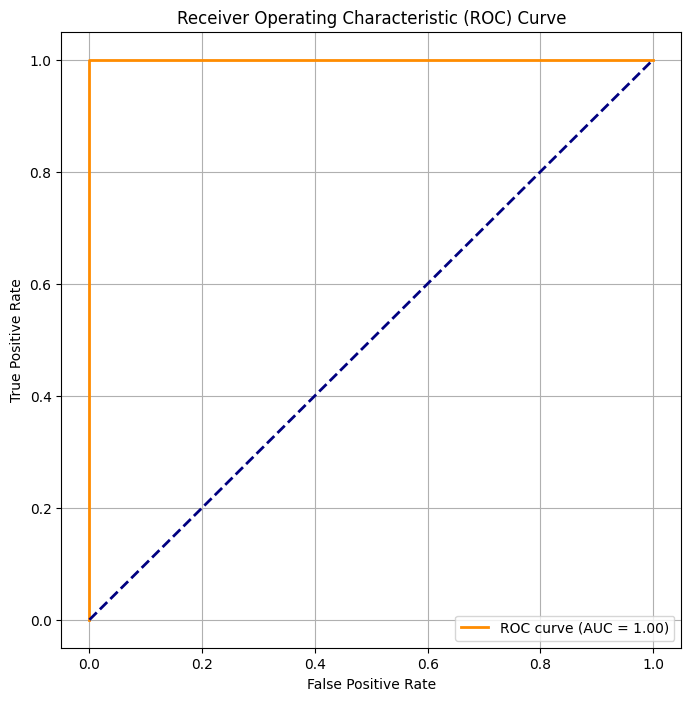

In [ ]:
gModel = globalOptimalModel['model']
with torch.no_grad(): output = gModel(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
gLr = globalOptimalModel['hyperparameters']['lr']
gEpochs = globalOptimalModel['hyperparameters']['epochs']
gBatchSize = globalOptimalModel['hyperparameters']['batchSize']
gLambda = globalOptimalModel['hyperparameters']['lambda']

index = int(np.where(thresholds == globalOptimalThreshold)[0])
FPR = fpr[index]
TPR = tpr[index]

print(f'Global Optimal Model Hyperparameters: lr={gLr}, epochs={gEpochs}, batchSize={gBatchSize}, lamda={gLambda}')
print(f'Global Optimal TPR: {TPR}, Global Optimal FPR: {FPR}, Global Optimal Threshold: {globalOptimalThreshold}')
print(f'Global Optimal Acc: {globalOptimalAcc}, Global Optimal Loss: {globalOptimalLoss}')

Global Optimal Model Hyperparameters: lr=1, epochs=500, batchSize=64, lamda=0.001
Global Optimal TPR: 1.0, Global Optimal FPR: 0.0, Global Optimal Threshold: 0.20195643603801727
Global Optimal Acc: 0.9921875, Global Optimal Loss: 0.16480794052282968


### Reproducability Test & Visualization

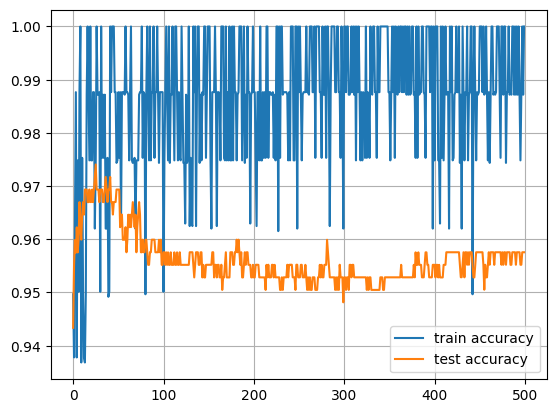

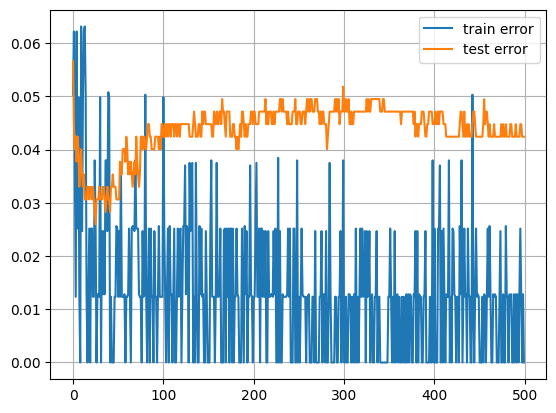

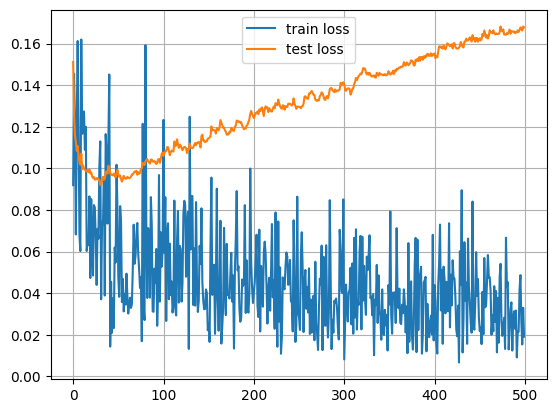

Train Accuracy: 1.0, Train Error: 0.0, Train Loss: 0.019066352397203445
Test Accuracy: 0.9575633469849832, Test Error: 0.04243665301501681, Test Loss: 0.16774755219618478


In [ ]:
lr = globalOptimalModel['hyperparameters']['lr']
epochs = globalOptimalModel['hyperparameters']['epochs']
batchSize = globalOptimalModel['hyperparameters']['batchSize']
lambda_ = globalOptimalModel['hyperparameters']['lambda']

num_features = len(X_train_df.columns)
model = LogisticRegression(num_features, l2=lambda_)
lossFn = nn.BCELoss()

trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModelKFold(
    model,
    epochs,
    lossFn,
    X_data,
    y_data,
    lr=lr,
    batchSize=batchSize,
    k=3,
)

model.eval()

plt.plot(trainAcc, label='train accuracy')
plt.plot(testAcc, label='test accuracy')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainErr, label='train error')
plt.plot(testErr, label='test error')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.grid(True)
plt.legend()

plt.show()


print(f'Train Accuracy: {trainAcc[-1]}, Train Error: {trainErr[-1]}, Train Loss: {trainLoss[-1]}')
print(f'Test Accuracy: {testAcc[-1]}, Test Error: {testErr[-1]}, Test Loss: {testLoss[-1]}')

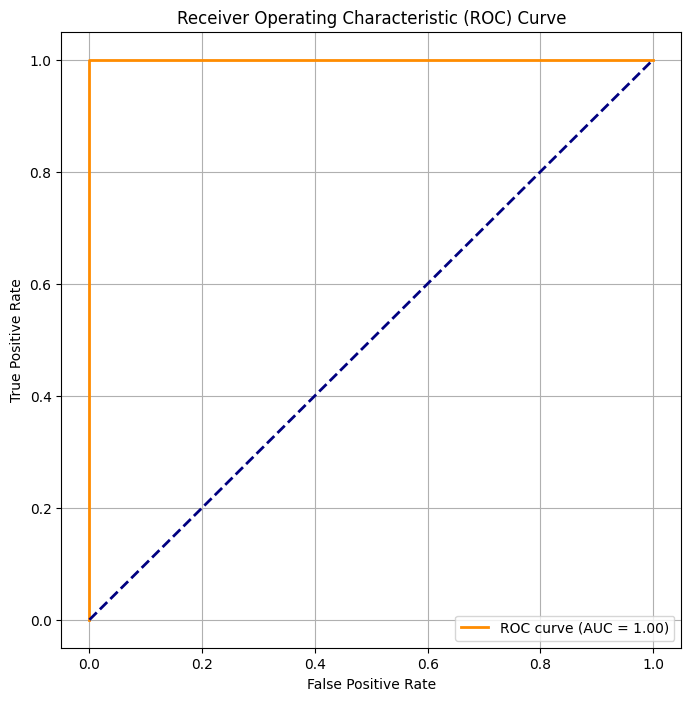

In [ ]:
with torch.no_grad(): output = model(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
optimalAcc, optimalThreshold = findOptimalThresholdForModelAcc(
        model,
        X_test_tensor,
        y_test_tensor,
    )

index = int(np.where(thresholds == optimalThreshold)[0])
FPR = fpr[index]
TPR = tpr[index]

print(f'Global Optimal Model Hyperparameters: lr={lr}, epochs={epochs}, batchSize={batchSize}, lamda={lambda_}')
print(f'Global Optimal TPR: {TPR}, Global Optimal FPR: {FPR}, Global Optimal Threshold: {optimalThreshold}')
print(f'Global Optimal Acc: {optimalAcc}, Global Optimal Loss: {testLoss[-1]}')

Global Optimal Model Hyperparameters: lr=1, epochs=500, batchSize=64, lamda=0.001
Global Optimal TPR: 1.0, Global Optimal FPR: 0.0, Global Optimal Threshold: 0.2340357005596161
Global Optimal Acc: 0.9921875, Global Optimal Loss: 0.16774755219618478


## Risk Minimization: Finding the Optimal Model such that it minimizes the risk by increasing true positive rate (TPR)

In [ ]:
def findOptimalThresholdForModel(model, X_test_tensor, y_test_tensor, fprThreshhold=0.25):
  with torch.no_grad(): output = model['model'](X_test_tensor).detach().numpy().flatten()
  fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output, pos_label=1)
  optimalTPR = None
  optimalFPR = None
  optimalThreshold = None

  for threshold in thresholds:
    index = int(np.where(thresholds == threshold)[0])
    FPR = fpr[index]
    TPR = tpr[index]

    if (optimalTPR == None):
      optimalThreshold = threshold
      optimalTPR = TPR
      optimalFPR = FPR
    elif (TPR > optimalTPR and FPR < fprThreshhold):
      optimalThreshold = threshold
      optimalTPR = TPR
      optimalFPR = FPR

    # print(f"Threshold: ---------------------- {threshold}")
    # print(f"True Positive Rate (Sensitivity): {TPR}")
    # print(f"False Positive Rate:              {FPR}")

  return optimalTPR, optimalFPR, optimalThreshold

In [ ]:
globalOptimalModel = None
globalOptimalTPR = None
globalOptimalFPR = None
globalOptimalThreshold = None

for model_ in trainedModels:
    optimalTPR, optimalFPR, optimalThreshold = findOptimalThresholdForModel(
        model_,
        X_test_tensor,
        y_test_tensor
    )

    if (globalOptimalTPR == None):
      globalOptimalTPR = optimalTPR
      globalOptimalFPR = optimalFPR
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalTPR > globalOptimalTPR):
      globalOptimalTPR = optimalTPR
      globalOptimalFPR = optimalFPR
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold
    elif (optimalTPR == globalOptimalTPR and optimalFPR < globalOptimalFPR):
      globalOptimalFPR = optimalFPR
      globalOptimalModel = model_
      globalOptimalThreshold = optimalThreshold

print(globalOptimalModel)

{'model': LogisticRegression(
  (layer1): Linear(in_features=30, out_features=1, bias=True)
  (sig): Sigmoid()
), 'hyperparameters': {'epochs': 500, 'lr': 1, 'batchSize': 32, 'lambda': 0}, 'trainingStats': {'testAcc': 0.9481403789165251, 'trainAcc': 1.0, 'testError': 0.05185962108347484, 'trainError': 0.0, 'testLoss': 0.20777703821659088, 'trainLoss': 0.016867472790181637}, 'trainingTime': 12.728836059570312}


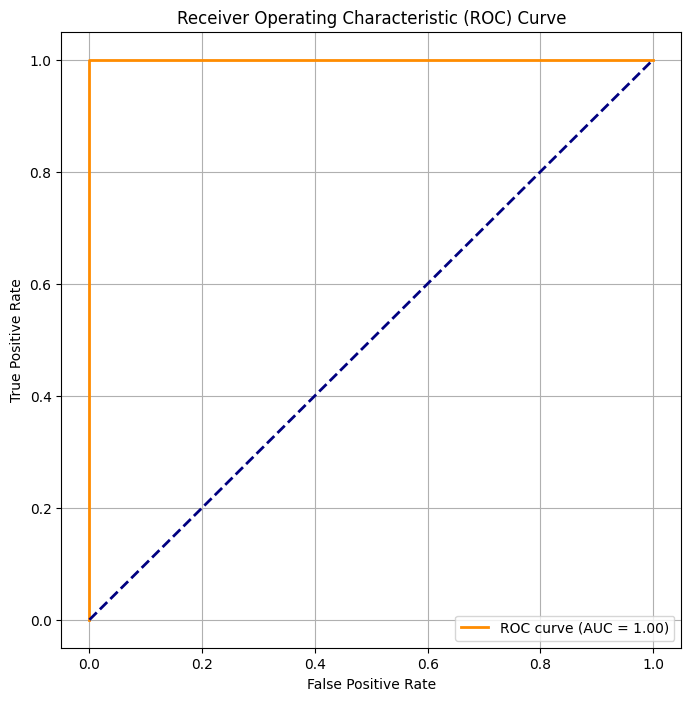

In [ ]:
gModel = globalOptimalModel['model']
with torch.no_grad(): output = gModel(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
gLr = globalOptimalModel['hyperparameters']['lr']
gEpochs = globalOptimalModel['hyperparameters']['epochs']
gbatchSize = globalOptimalModel['hyperparameters']['batchSize']
gLambda = globalOptimalModel['hyperparameters']['lambda']

with torch.no_grad(): output = gModel(X_test_tensor)
testPredictions = (np.array(output.detach().numpy().flatten()) > globalOptimalThreshold).astype(int)
testError = np.mean(testPredictions != np.array(y_test).astype(int))

print(f'Global Optimal Model Hyperparameters: lr={gLr}, epochs={gEpochs}, batchSize={gbatchSize}, lamda={gLambda}')
print(f'Global Optimal TPR: {globalOptimalTPR}, Global Optimal FPR: {globalOptimalFPR}, Global Optimal Threshold: {globalOptimalThreshold}')
print(f'Test Accuracy: {1-testError}, Test Error: {testError}')

Global Optimal Model Hyperparameters: lr=1, epochs=500, batchSize=32, lamda=0
Global Optimal TPR: 1.0, Global Optimal FPR: 0.0, Global Optimal Threshold: 0.27397364377975464
Test Accuracy: 0.9921875, Test Error: 0.0078125


### Re-produceability Test & Visualization

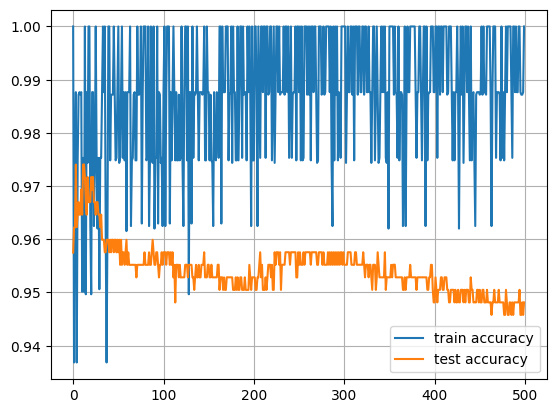

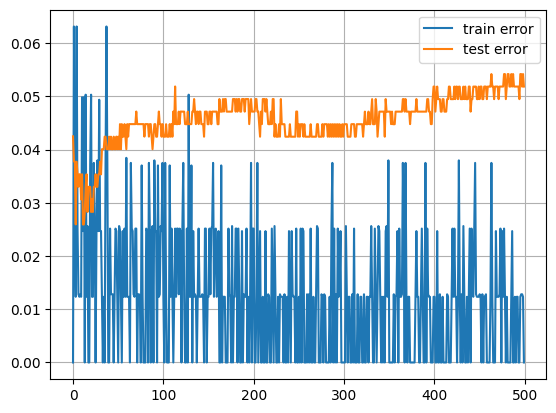

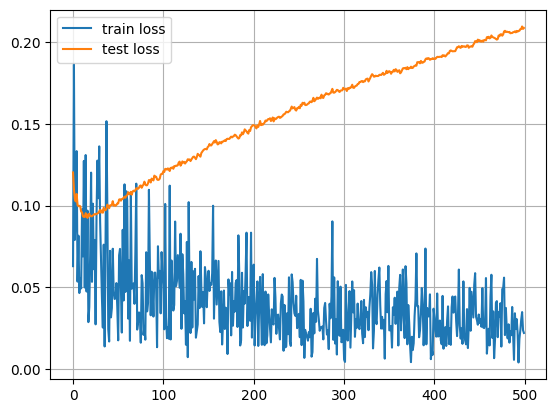

Train Accuracy: 1.0, Train Error: 0.0, Train Loss: 0.022152839849392574
Test Accuracy: 0.9481403789165251, Test Error: 0.05185962108347484, Test Loss: 0.20859554409980774


In [ ]:
lr = globalOptimalModel['hyperparameters']['lr']
epochs = globalOptimalModel['hyperparameters']['epochs']
batchSize = globalOptimalModel['hyperparameters']['batchSize']
lambda_ = globalOptimalModel['hyperparameters']['lambda']


num_features = len(X_train_df.columns)
model = LogisticRegression(num_features, l2=lambda_)
lossFn = nn.BCELoss()

trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModelKFold(
    model,
    epochs,
    lossFn,
    X_data,
    y_data,
    lr=lr,
    batchSize=batchSize,
    k=3
)

model.eval()

plt.plot(trainAcc, label='train accuracy')
plt.plot(testAcc, label='test accuracy')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainErr, label='train error')
plt.plot(testErr, label='test error')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.grid(True)
plt.legend()

plt.show()


print(f'Train Accuracy: {trainAcc[-1]}, Train Error: {trainErr[-1]}, Train Loss: {trainLoss[-1]}')
print(f'Test Accuracy: {testAcc[-1]}, Test Error: {testErr[-1]}, Test Loss: {testLoss[-1]}')

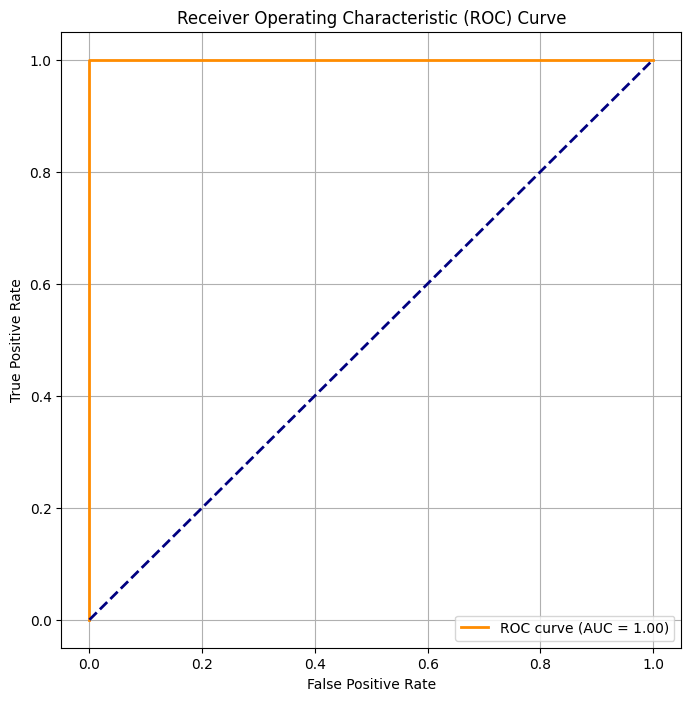

In [ ]:
with torch.no_grad(): output = model(X_test_tensor)
fpr, tpr, thresholds = roc_curve(y_test_tensor.detach().numpy(), output.detach().numpy().flatten(), pos_label=1)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(rocAUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
optimalTPR, optimalFPR, optimalThreshold = findOptimalThresholdForModel(
        { 'model': model },
        X_test_tensor,
        y_test_tensor
)

testPredictions = (np.array(output.detach().numpy().flatten()) > optimalThreshold).astype(int)
testError = np.mean(testPredictions != np.array(y_test).astype(int))

print(f'Re: Global Optimal Model Hyperparameters: lr={lr}, epochs={epochs}, batchSize={batchSize}, lambda={lambda_}')
print(f'Re: Global Optimal TPR: {optimalTPR}, Global Optimal FPR: {optimalFPR}, Global Optimal Threshold: {optimalThreshold}')
print(f'Re: Test Accuracy: {1-testError}, Test Error: {testError}')

Re: Global Optimal Model Hyperparameters: lr=1, epochs=500, batchSize=32, lambda=0
Re: Global Optimal TPR: 1.0, Global Optimal FPR: 0.0, Global Optimal Threshold: 0.2831031382083893
Re: Test Accuracy: 0.9921875, Test Error: 0.0078125


## Time Complexity Analysis

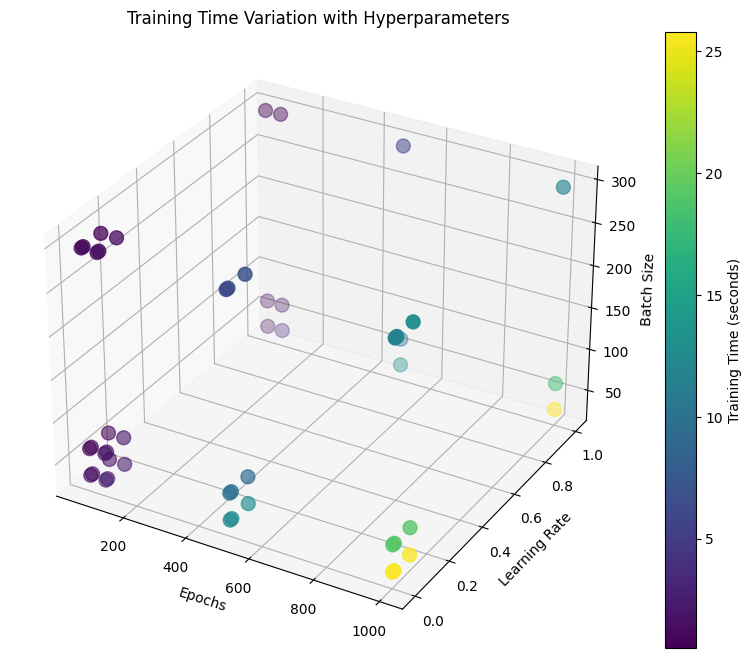

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lambdaValue = 0.001
filteredModels = [modelInfo for modelInfo in trainedModels if modelInfo['hyperparameters']['lambda'] == lambdaValue]

epochsList = [modelInfo['hyperparameters']['epochs'] for modelInfo in filteredModels]
learningRates = [modelInfo['hyperparameters']['lr'] for modelInfo in filteredModels]
batchSizes = [modelInfo['hyperparameters']['batchSize'] for modelInfo in filteredModels]
trainingTimes = [modelInfo['trainingTime'] for modelInfo in filteredModels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(epochsList, learningRates, batchSizes, c=trainingTimes, cmap='viridis', marker='o', s=100)
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Batch Size')
ax.set_title('Training Time Variation with Hyperparameters')
cbar = plt.colorbar(sc)
cbar.set_label('Training Time (seconds)')

plt.show()
